In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import utils  # we define some useful shortcuts here

np.random.seed(0)
pd.options.display.max_rows = 10

## 1. Import Dataset
Concrete Compressive Strength Data Set

In [13]:
df = pd.read_excel('./data/Concrete_Data.xls', sheet_name='Sheet1')
df

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1024,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1025,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1026,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1027,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


#### Train-test split

In [94]:
from sklearn.model_selection import train_test_split

X, y = df[df.columns[:-1]], df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5
)

In [95]:
from sklearn.preprocessing import MinMaxScaler
# Scale inputs
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Build a Prediction Model

### 2.1 Linear Regression Baseline
We first consider a linear regression baseline, where we fit a linear model

To do this we simply import the function from sklearn.

In [96]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train_scaled)  # Training set predictions
y_hat_test = regressor.predict(X_test_scaled)  # Test set predictions

In [97]:
from sklearn.metrics import mean_squared_error
def plot_predictions(y, y_hat, labels):
 
  
    plt.rcParams.update({'font.size': 18, 'font.sans-serif':'arial'})
    y, y_hat, labels = list(
        map(
            lambda l: l if isinstance(l, list) else [l],
            [y, y_hat, labels]))
    color_list = ['blue', 'red']
    n_plots = len(y)
    y_min = min([min(z) for z in y])
    y_max = max([max(z) for z in y])
    lims = (y_min, y_max)
    fig, ax = plt.subplots(
        1, n_plots, figsize=(6*n_plots, 5),
        squeeze=False, sharex=True, sharey=True)
    for axis, target, prediction, label, color in zip(ax[0, :], y, y_hat, labels, color_list):
        # Scatter plot
        axis.scatter(target, prediction, alpha=0.3, c = color)

        # Title and labels
        rmse_value = np.sqrt(mean_squared_error(target, prediction))
        title = label + " (RMSE=%.3f)" % rmse_value
        axis.set_title(title)
        axis.set_xlabel('Target Compressive Strength (MPa)')
        axis.set_ylabel('Predicted Compressive Strength (MPa)')
        axis.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
        axis.yaxis.set_tick_params(which='both', labelleft=True)

    plt.subplots_adjust(wspace = 0.3)
    plt.show()


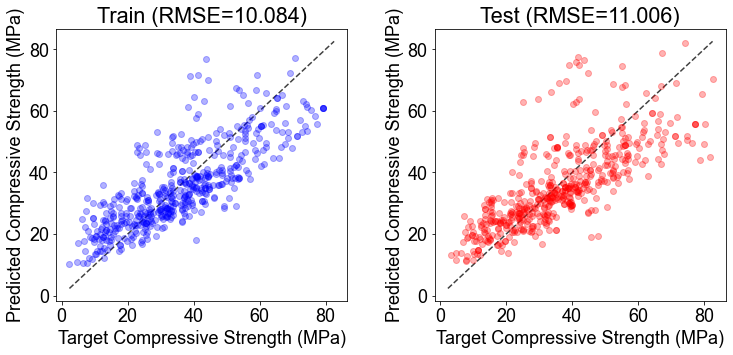

In [98]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

### 2.2 Gradient Boosting Regression

In [99]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)
y_hat_test = regressor.predict(X_test)

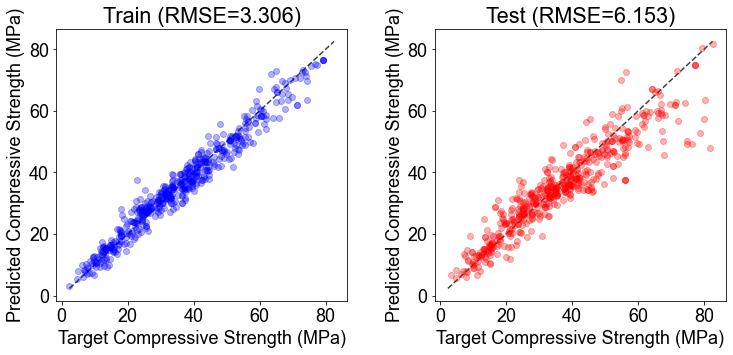

In [100]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

#### Over-Fitting


In [75]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(max_depth=100)
regressor.fit(X_train, y_train)

y_hat_train = regressor.predict(X_train)
y_hat_test = regressor.predict(X_test)

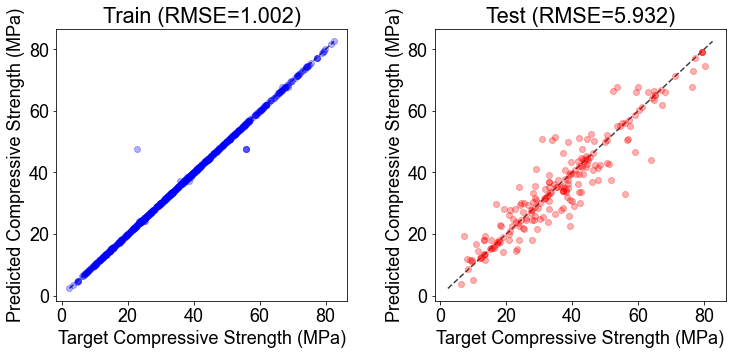

In [76]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

#### Hyper-parameter Tuning

There are many parameters one can tune (e.g. learning_rate, n_estimators etc.). We call these *hyper-parameters*, in the sense that they are parameters controlling the properties of the regressor, and are not the *trainable* parameters during model fitting. 

To maximize performance, we have to tune these parameters. To do this, we use *random search cross-validation tuning*. Let us briefly explain each term

- Cross-validation: This refers to scoring the performance of a model under a set of hyper-parameters given the training set. The idea is to further split the training set into two
    * train set (to be used for training, e.g. 2/3 of original training data)
    * validation set (to be used for evaluation of accuracy, 1/3 of original training data)

By averaging over the 3 possible splits, we can have an average score of this particular selection of hyper-parameters. The goal is maximize this score over the hyper-parameter space. This is called *3-fold* cross-validation.
- Grid search: define the grid and iteratively calculate all the combination of hyper-parameters 
- Random search: Instead of performing a grid search over all hyper-parameters, it is usualy more efficient to randomly sample them from some distributions and at each CV run, we pick a random hyper-parameter combination.

##### Tuning via Grid Search CV

In [108]:
from scipy import stats 
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 3, 4,5],
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]
}

regressor_cv = GridSearchCV(
    regressor, parameters, verbose=1)
regressor_cv.fit(X_train, y_train)

print('Best params: \n', regressor_cv.best_params_)

y_hat_train = regressor_cv.predict(X_train)
y_hat_test = regressor_cv.predict(X_test)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 11.3min finished


Best params: 
 {'learning_rate': 0.25, 'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 500}


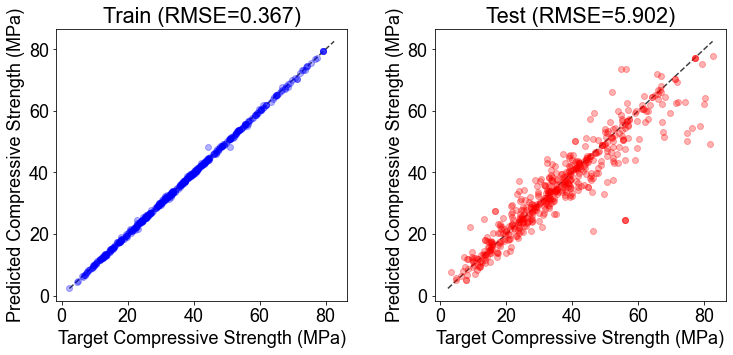

In [106]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

##### Tuning via Grid Search CV

In [25]:
from scipy import stats 
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': stats.randint(low=10, high=1000),
    'max_depth': stats.randint(low=2, high=6),
    'min_samples_split': stats.randint(low=2, high=5),
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]
}


regressor_cv = RandomizedSearchCV(
    regressor, param_distributions=param_distributions,
    n_iter=50, verbose=1)
regressor_cv.fit(X_train, y_train)

print('Best params: \n', regressor_cv.best_params_)

y_hat_train = regressor_cv.predict(X_train)
y_hat_test = regressor_cv.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  3.5min finished


Best params: 
 {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 767}


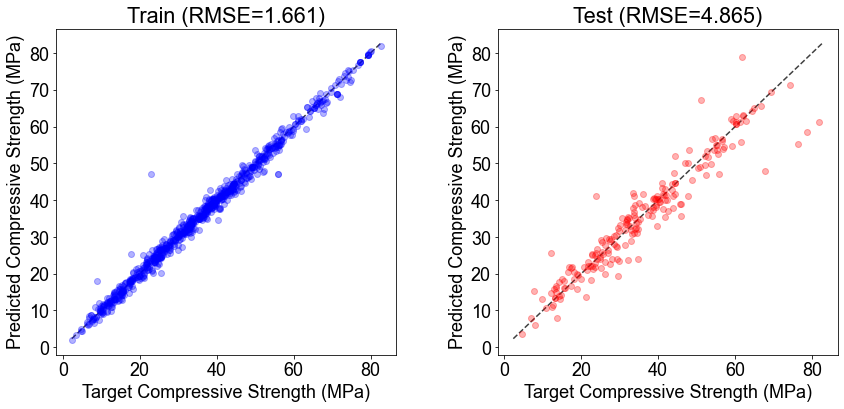

In [26]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

### 2.2 Neural Network Regression

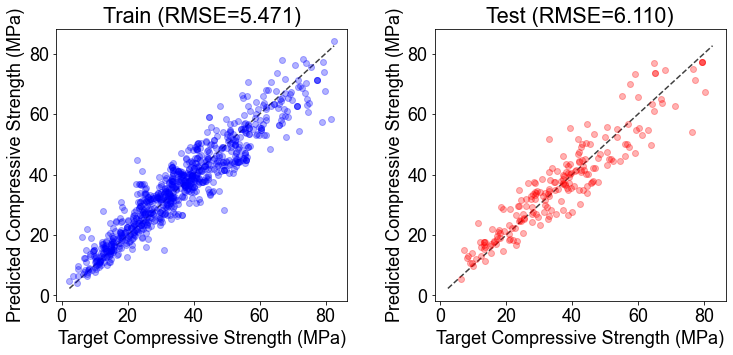

In [63]:
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor(
    hidden_layer_sizes=[256, 128, 64], max_iter=1000)
regressor.fit(X_train_scaled, y_train)
y_hat_train = regressor.predict(X_train_scaled)
y_hat_test = regressor.predict(X_test_scaled)

# Plot predictions
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

#### Over-fitting
For demo purposes, we are going to fit the NN on a smaller dataset
instead of going for a much bigger network (and training for a long time)


In [72]:
X_train1, y_train1 = X_train[:50], y_train[:50]
X_train_scaled1, X_test_scaled = \
    map(scaler.transform, [X_train1, X_test])

regressor = MLPRegressor(
    hidden_layer_sizes=[256, 128, 64], max_iter=100, warm_start=True,
    solver='sgd', alpha=0, momentum=0,
    learning_rate='adaptive', learning_rate_init=1e-3)

In [74]:
from sklearn.metrics import mean_squared_error as mse
import logging
# Train and log the losses
n_iter = 50
train_losses, test_losses = [], []
for n in range(n_iter):
    regressor.fit(X_train_scaled1, y_train1)
    train_losses.append(
        np.sqrt(mse(regressor.predict(X_train_scaled1), y_train1)))
    test_losses.append(
        np.sqrt(mse(regressor.predict(X_test_scaled), y_test)))
    logging.info(
        'Iteration %d | Train loss %.3f | Test loss %.3f'
        % (n, train_losses[-1], test_losses[-1]))

y_hat_train = regressor.predict(X_train_scaled)
y_hat_test = regressor.predict(X_test_scaled)

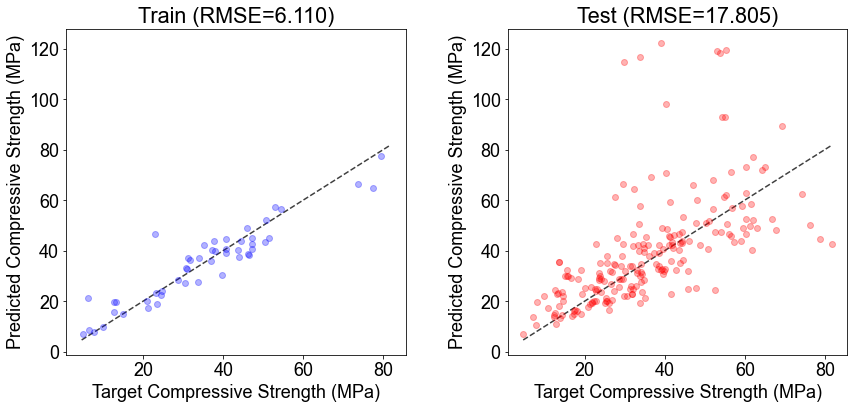

In [43]:
plot_predictions([y_train, y_test], [y_hat_train, y_hat_test],    labels=['Train', 'Test'])

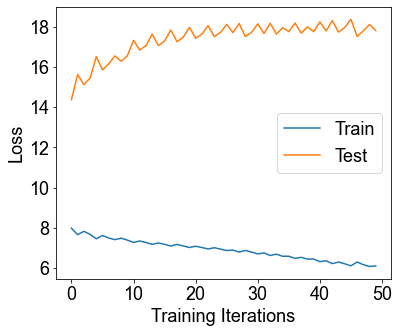

In [69]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for loss, label in zip([train_losses, test_losses], ['Train', 'Test']):
    ax.plot(loss, label=label)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Training Iterations')
    ax.legend()